In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 100

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-100-lev-50/model.ckpt-965.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-100-lev-50/model.ckpt-965


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 50

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [15]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e6 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [16]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [17]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, ShortCommonDPLL)
    logfile.flush()


  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas



100%|██████████| 100/100 [04:38<00:00,  4.04s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 194.11; stdev step: 242.28; avg error: 1.15; stdev error: 1.42


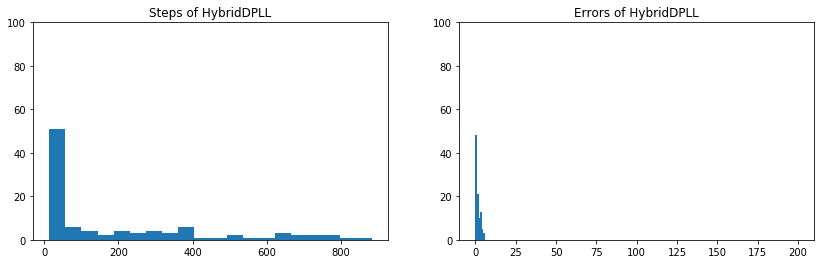

100%|██████████| 100/100 [00:01<00:00, 41.54it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 236.76; stdev step: 211.16; avg error: 2.35; stdev error: 1.40


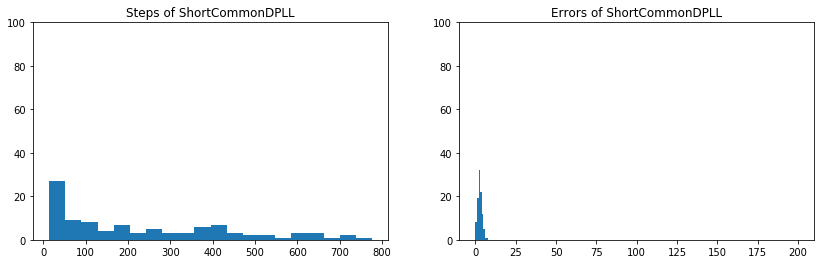

In [27]:
print_all(100, 200, 15)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:08<00:00,  1.82it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.88; stdev step: 29.79; avg error: 0.31; stdev error: 0.48


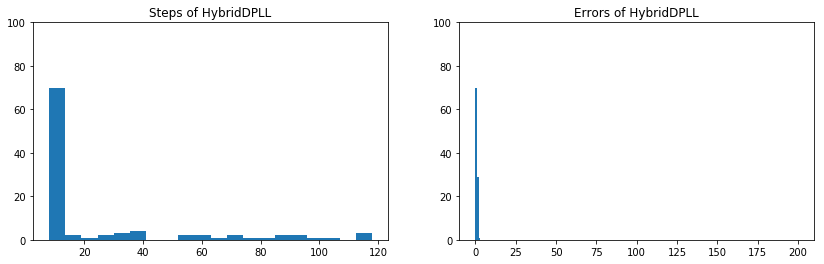

100%|██████████| 100/100 [00:00<00:00, 468.75it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.47; stdev step: 22.43; avg error: 0.98; stdev error: 0.94


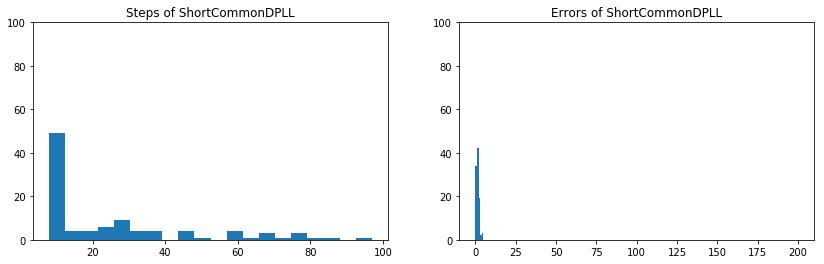

In [28]:
print_all(100, 200, 8)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:08<00:00,  1.14s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 45.33; stdev step: 56.09; avg error: 0.39; stdev error: 0.55


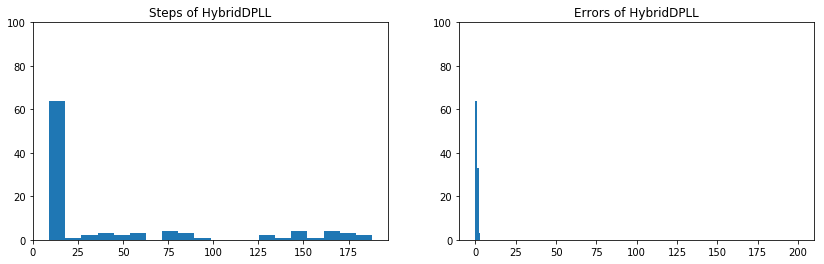

100%|██████████| 100/100 [00:00<00:00, 252.38it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 56.13; stdev step: 44.51; avg error: 1.46; stdev error: 0.92


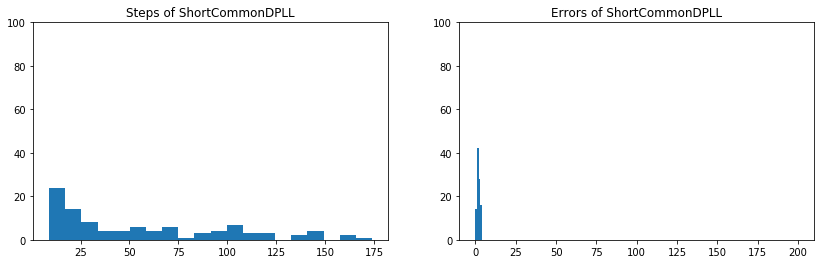

In [29]:
print_all(100, 200, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [03:16<00:00,  1.91s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 88.11; stdev step: 116.44; avg error: 0.68; stdev error: 1.01


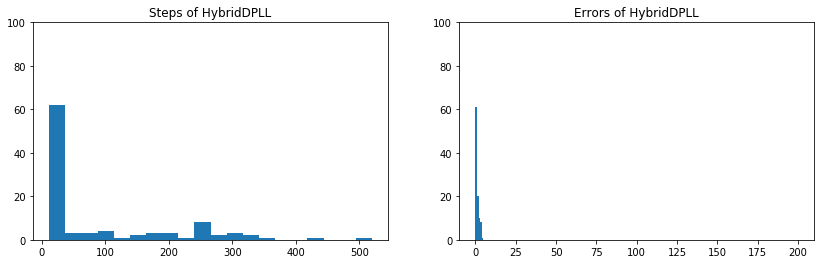

100%|██████████| 100/100 [00:00<00:00, 138.34it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 84.89; stdev step: 75.93; avg error: 1.67; stdev error: 0.94


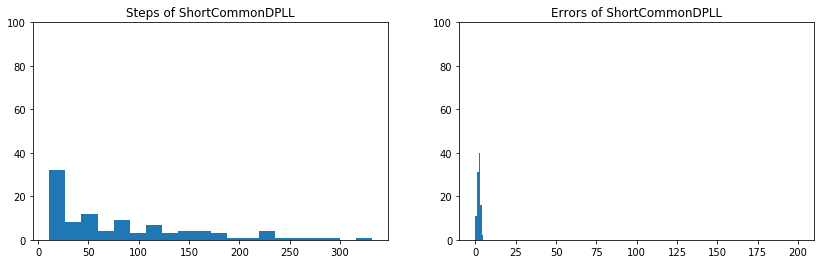

In [30]:
print_all(100, 200, 12)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [03:54<00:00,  3.91s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 135.02; stdev step: 177.04; avg error: 0.84; stdev error: 1.09


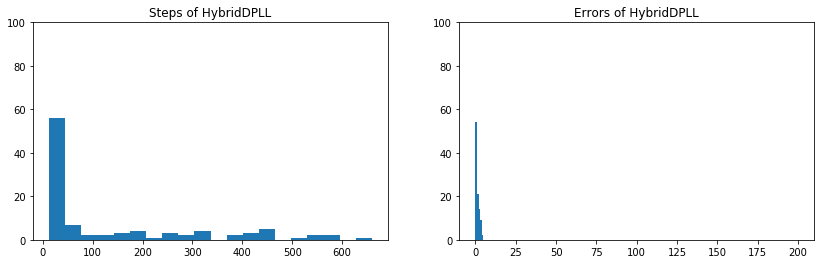

100%|██████████| 100/100 [00:01<00:00, 83.17it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 143.78; stdev step: 146.11; avg error: 1.87; stdev error: 1.27


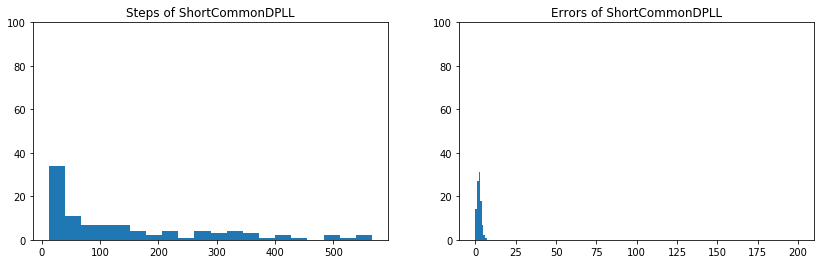

In [31]:
print_all(100, 200, 14)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [05:39<00:00,  4.86s/it]


Within 1e6 steps solved 94 problems out of 100
#Sats: 94; avg step: 250.50; stdev step: 271.83; avg error: 1.50; stdev error: 1.54


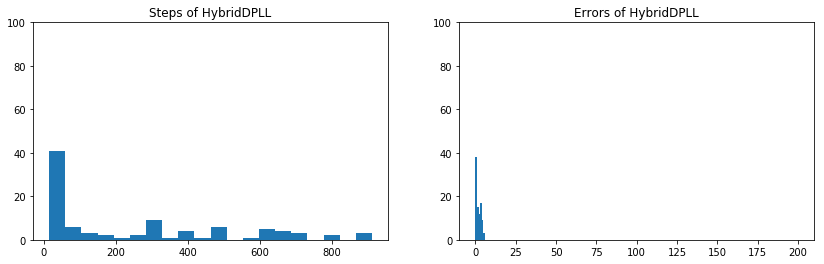

100%|██████████| 100/100 [00:02<00:00, 39.05it/s]


Within 1e6 steps solved 98 problems out of 100
#Sats: 98; avg step: 282.14; stdev step: 262.30; avg error: 2.45; stdev error: 1.32


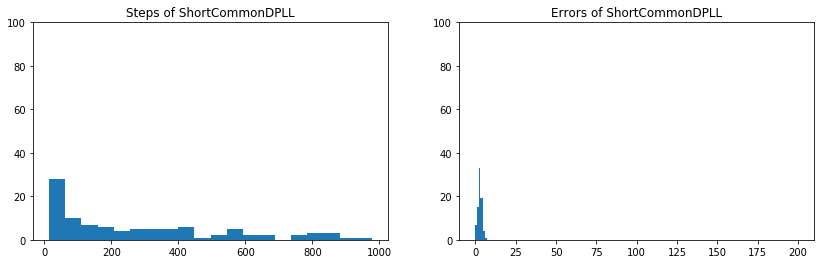

In [32]:
print_all(100, 200, 16)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [05:54<00:00,  4.19s/it]


Within 1e6 steps solved 85 problems out of 100
#Sats: 85; avg step: 217.78; stdev step: 257.71; avg error: 1.11; stdev error: 1.35


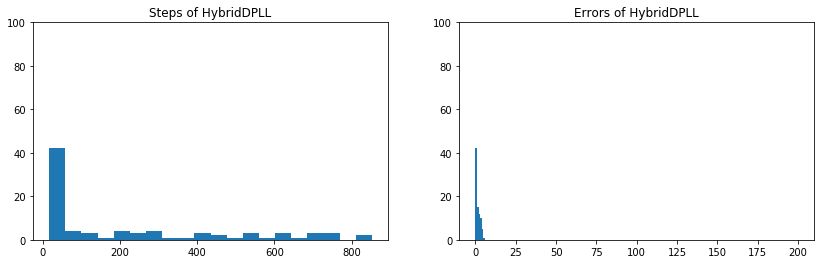

100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


Within 1e6 steps solved 88 problems out of 100
#Sats: 88; avg step: 388.49; stdev step: 305.83; avg error: 2.74; stdev error: 1.44


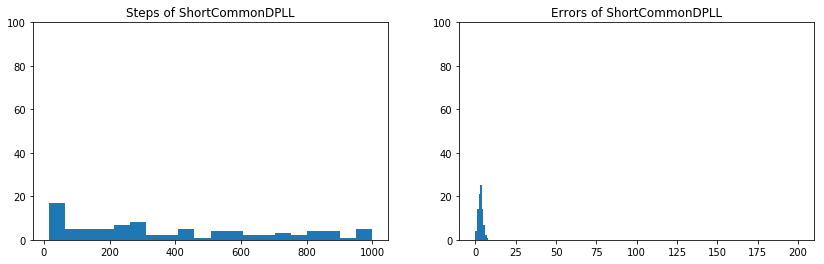

In [33]:
print_all(100, 200, 18)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [06:35<00:00,  5.27s/it]


Within 1e6 steps solved 68 problems out of 100
#Sats: 68; avg step: 252.59; stdev step: 311.46; avg error: 1.38; stdev error: 1.73


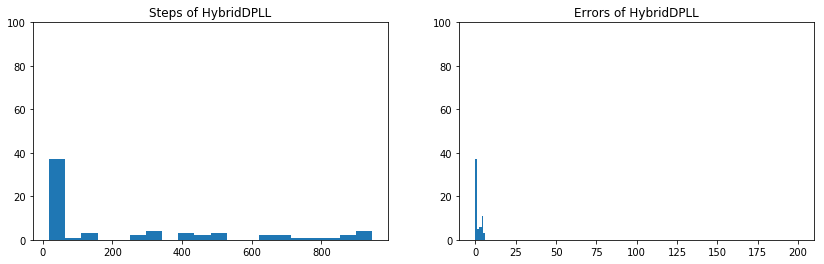

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


Within 1e6 steps solved 59 problems out of 100
#Sats: 59; avg step: 351.58; stdev step: 272.97; avg error: 3.17; stdev error: 1.18


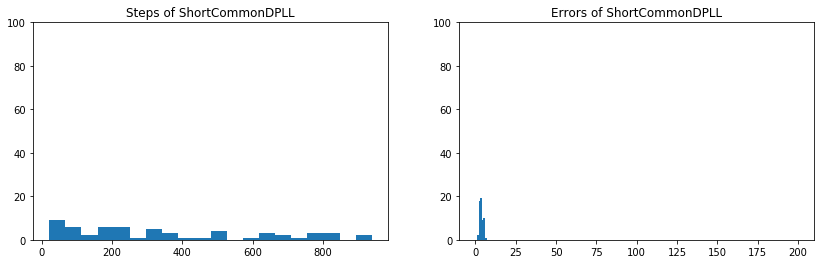

In [34]:
print_all(100, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [08:04<00:00,  6.00s/it]


Within 1e6 steps solved 58 problems out of 100
#Sats: 58; avg step: 168.81; stdev step: 244.69; avg error: 0.84; stdev error: 1.40


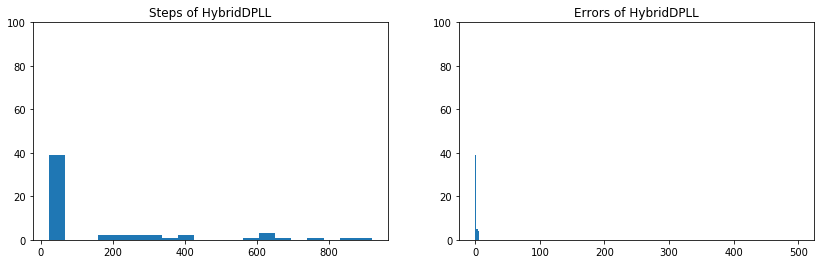

100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Within 1e6 steps solved 36 problems out of 100
#Sats: 36; avg step: 350.28; stdev step: 301.49; avg error: 3.14; stdev error: 1.70


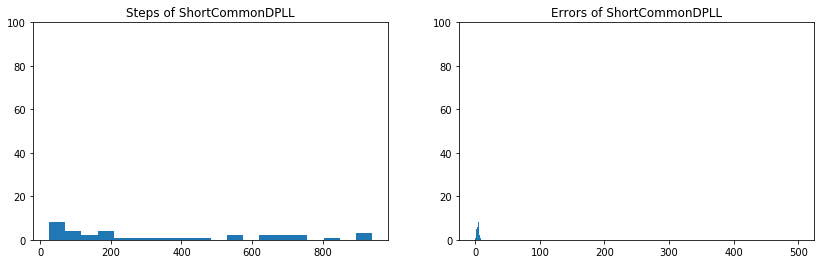

In [35]:
print_all(100, 500, 25)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [10:09<00:00,  6.90s/it]


Within 1e6 steps solved 31 problems out of 100
#Sats: 31; avg step: 160.65; stdev step: 244.12; avg error: 0.84; stdev error: 1.35


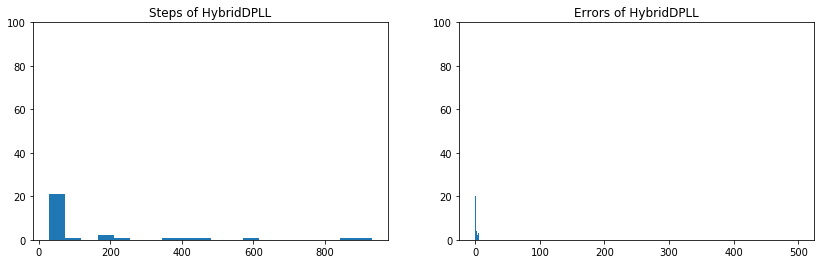

100%|██████████| 100/100 [00:10<00:00,  8.40it/s]


Within 1e6 steps solved 15 problems out of 100
#Sats: 15; avg step: 358.27; stdev step: 319.08; avg error: 3.47; stdev error: 1.50


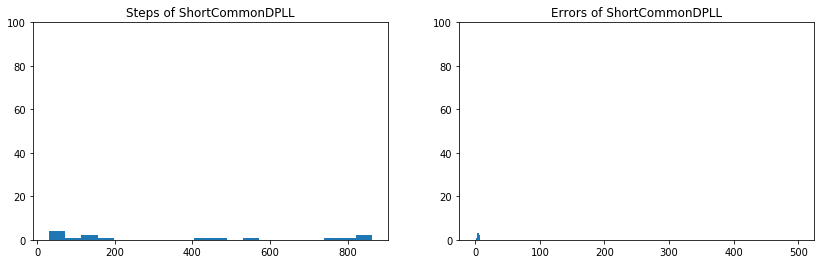

In [36]:
print_all(100, 500, 30)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [13:10<00:00,  8.68s/it]


Within 1e6 steps solved 25 problems out of 100
#Sats: 25; avg step: 155.48; stdev step: 159.50; avg error: 1.20; stdev error: 1.81


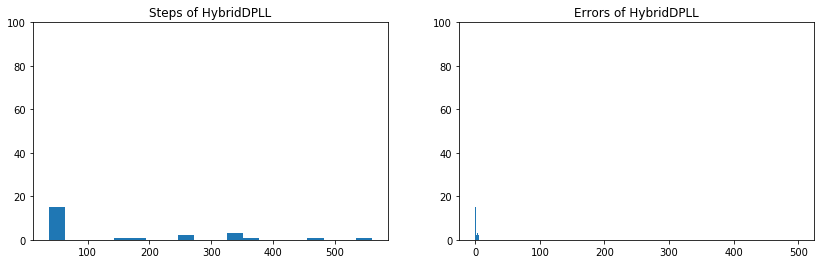

100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Within 1e6 steps solved 3 problems out of 100
#Sats: 3; avg step: 164.67; stdev step: 108.33; avg error: 3.33; stdev error: 0.47


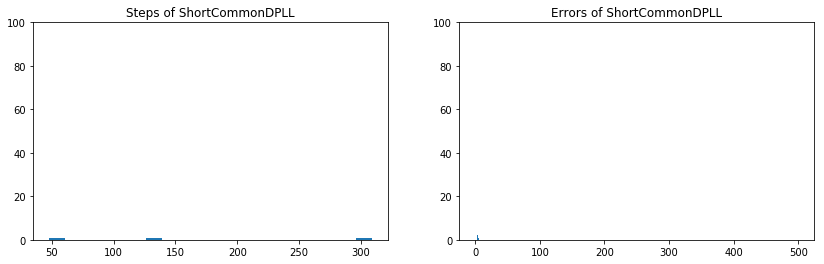

In [37]:
print_all(100, 500, 40, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [17:26<00:00, 10.78s/it]


Within 1e6 steps solved 6 problems out of 100
#Sats: 6; avg step: 126.67; stdev step: 108.55; avg error: 0.67; stdev error: 1.11


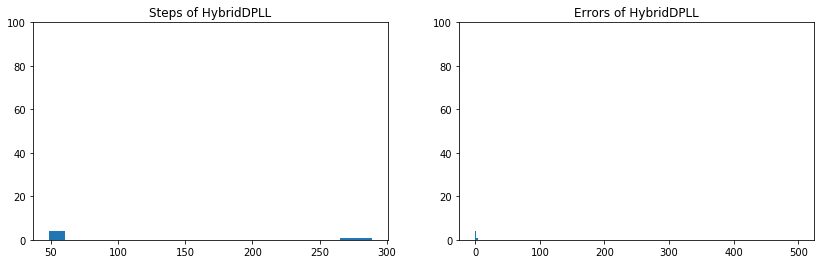

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


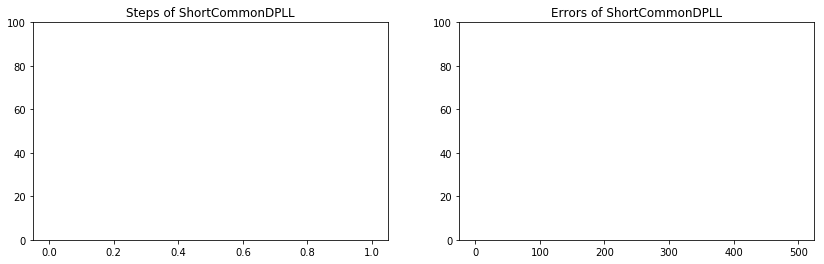

In [38]:
print_all(100, 500, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [29:09<00:00, 18.90s/it]


Within 1e6 steps solved 4 problems out of 100
#Sats: 4; avg step: 70.00; stdev step: 1.73; avg error: 0.00; stdev error: 0.00


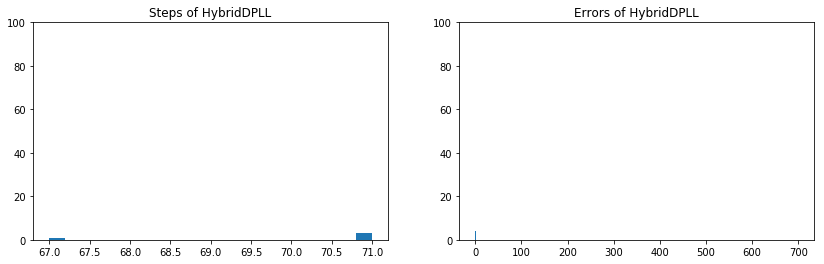

100%|██████████| 100/100 [00:25<00:00,  4.84it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


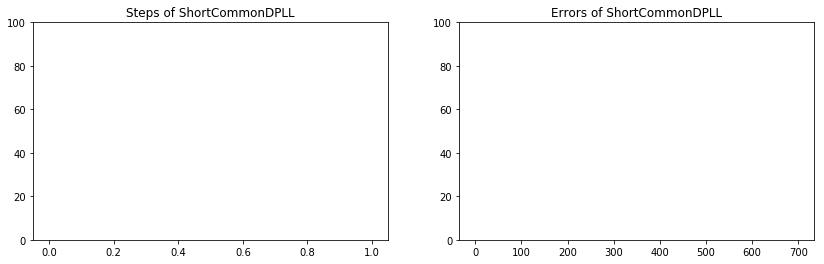

In [39]:
print_all(100, 700, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [44:53<00:00, 27.46s/it]


Within 1e6 steps solved 2 problems out of 100
#Sats: 2; avg step: 88.50; stdev step: 0.50; avg error: 0.00; stdev error: 0.00


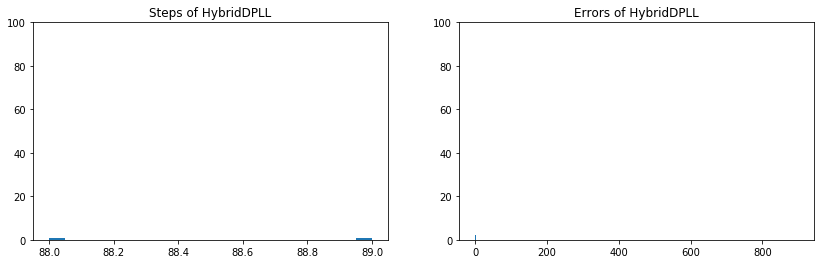

100%|██████████| 100/100 [00:35<00:00,  3.03it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


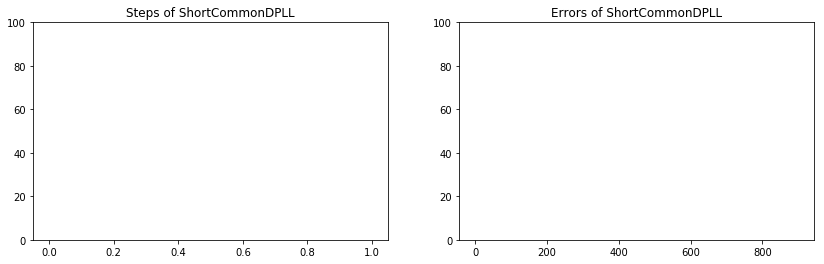

In [40]:
print_all(100, 900, 90, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [47:58<00:00, 29.12s/it]


Within 1e6 steps solved 3 problems out of 100
#Sats: 3; avg step: 222.67; stdev step: 162.87; avg error: 1.00; stdev error: 1.41


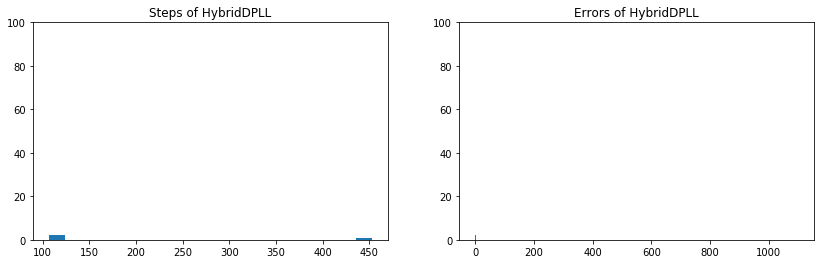

100%|██████████| 100/100 [00:46<00:00,  1.82it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


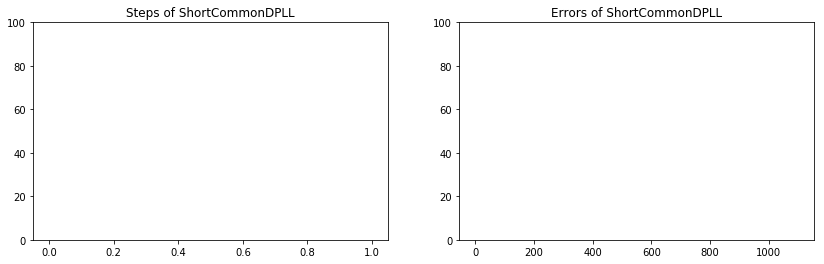

In [41]:
print_all(100, 1100, 110, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [1:04:03<00:00, 38.34s/it]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dt

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


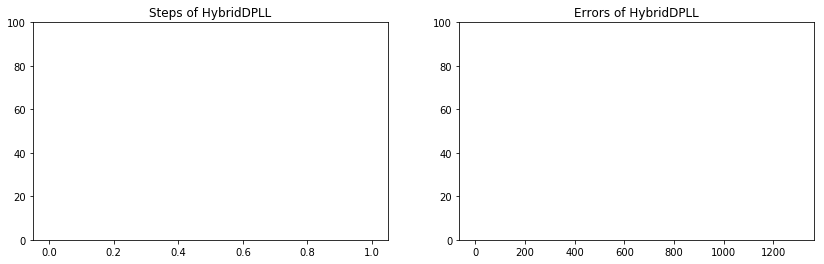

100%|██████████| 100/100 [00:51<00:00,  2.11it/s]


Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


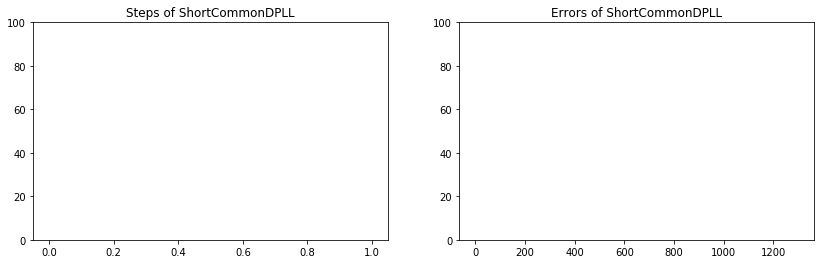

In [42]:
print_all(100, 1300, 130, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [1:20:37<00:00, 48.93s/it]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dt

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


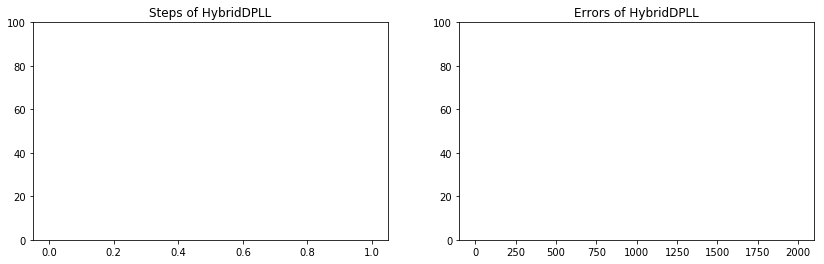

100%|██████████| 100/100 [01:16<00:00,  1.21it/s]


Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


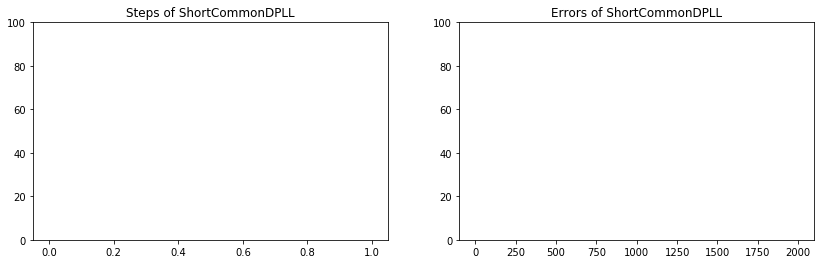

In [43]:
print_all(100, 2000, 150, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [31:44<00:00, 18.81s/it]


Within 1e6 steps solved 2 problems out of 100
#Sats: 2; avg step: 68.50; stdev step: 0.50; avg error: 0.00; stdev error: 0.00


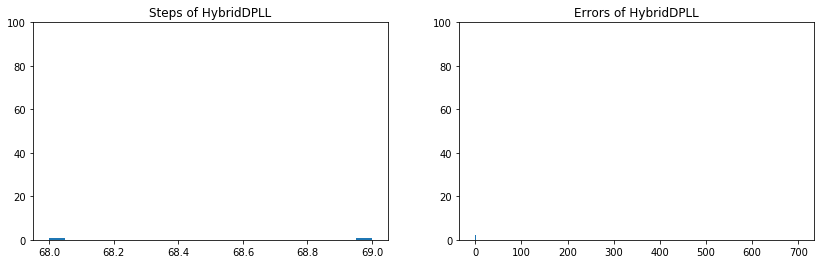

100%|██████████| 100/100 [00:25<00:00,  3.65it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


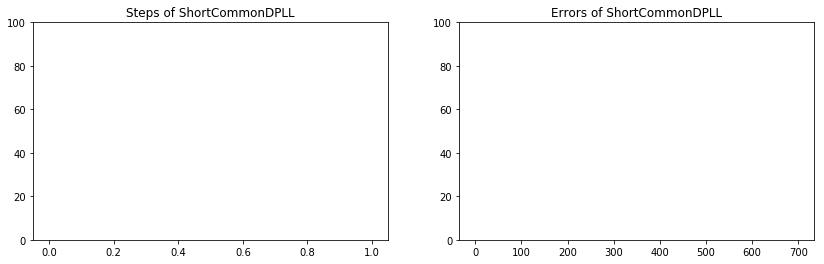

In [44]:
print_all(100, 700, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [37:22<00:00, 22.21s/it]


Within 1e6 steps solved 1 problems out of 100
#Sats: 1; avg step: 79.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


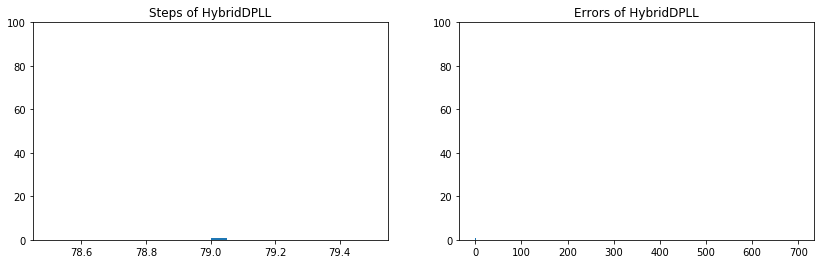

100%|██████████| 100/100 [00:27<00:00,  3.11it/s]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp

Within 1e6 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


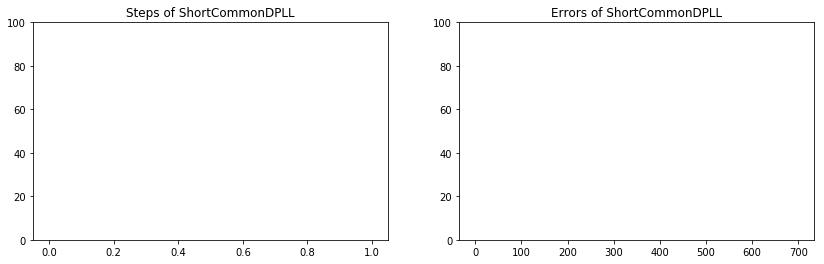

In [45]:
print_all(100, 700, 80, light=True)